In [61]:
import pandas as pd
import pandas as pd
import numpy as np
import re

# from sklearn.feature_extraction.text import TfidfVectorizer,CountVectorizer
from sklearn.model_selection import train_test_split
from nltk.corpus import stopwords
from nltk import  word_tokenize
from collections import Counter
import matplotlib.pyplot as plt
from wordcloud import WordCloud
import seaborn as sns
from sklearn.metrics import classification_report, f1_score, accuracy_score, confusion_matrix,recall_score,precision_score
from keras.preprocessing.text import Tokenizer
from keras.utils import pad_sequences
from keras.utils import to_categorical
from keras.layers import Dense, Input, GlobalMaxPooling1D, Dropout
from keras.layers import Conv1D, MaxPooling1D, Embedding
from keras.models import Model
from keras.initializers import Constant
from matplotlib import pyplot
from keras import backend as K
from keras.layers import Activation, Conv2D, Input, Embedding, Reshape, MaxPool2D, Concatenate, Flatten, Dropout, Dense, Conv1D
from keras.layers import MaxPool1D
from keras.models import Model

# glove vectorizer dependencies
from scipy import spatial
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE
import io
import os

filePath = 'TOTAL_TEXTS_SETOPATI.csv'
VALIDATION_SPLIT = 0.3
MAX_SEQUENCE_LENGTH = 1000
MAX_NUM_WORDS = 20000
EMBEDDING_DIM = 300

# Read csv dataset and save to df
df = pd.read_csv(filePath)
# print("First:" + df['text'][18])
print("DataFrame Size: "+ str(df.size))
#Preprocessing {Remove Stop words using nltk}
stop_words = stopwords.words("nepali")
def string_manipulation(df,column)  : 
    df[column] = df[column].apply(lambda x: re.sub('[।(),०-९<<?!,—,–,/,’,‘,:,\u200d]', '', x))
    df[column] = df[column].apply(lambda x: " ".join([i for i in x.split()if i not in (stop_words)]))
    return df
Data = string_manipulation(df,"text")
# Data = Data.sample(frac=1,random_state=20).reset_index(drop=True)
# Data['text'][18]
# print(stop_words)
# todo remove null or empty cells

# Split overall data into training (70%) and testing (30%)
# training_data, testing_data = train_test_split(Data, test_size = VALIDATION_SPLIT, random_state=25)
# print(f"No. of training examples: {training_data.shape[0]}")
# print(f"No. of testing examples: {testing_data.shape[0]}")

# convert word into vector
print('Indexing word vectors.')
embeddings_dict = {}
# Replaced glove.6B.50d.txt 
with open("processed.glove.txt", 'r', encoding='utf-8') as f:
    for line in f:
        values = line.split()
#         print(values)
        token = values[0]
        vector = np.asarray(values[1:], "float32")
        embeddings_dict[token] = vector

print('Found %s word vectors.' % len(embeddings_dict))


DataFrame Size: 520235
Indexing word vectors.
Found 663562 word vectors.


In [48]:
def recall_m(y_true, y_pred):
        true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
        possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
        recall = true_positives / (possible_positives + K.epsilon())
        return recall

def precision_m(y_true, y_pred):
        true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
        predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
        precision = true_positives / (predicted_positives + K.epsilon())
        return precision

def f1_m(y_true, y_pred):
    precision = precision_m(y_true, y_pred)
    recall = recall_m(y_true, y_pred)
    return 2*((precision*recall)/(precision+recall+K.epsilon()))

In [49]:
# second, prepare text samples and their labels
print('Processing text dataset')

newsTexts = Data['text'].tolist()
labels_index = {}  # dictionary mapping label name to numeric id
labels = [] # list of label ids
allCategoryDataList = Data['catagory']

indexCount = 0
for category in allCategoryDataList.unique():
    labels_index[category] = indexCount
    indexCount = indexCount + 1

for category in allCategoryDataList.tolist():
    labels.append(labels_index[category])
        
print('Found %s news texts.' % len(newsTexts))
print('Found %s news labels.' % len(labels))


Processing text dataset
Found 104047 news texts.
Found 104047 news labels.


In [50]:
# finally, vectorize the text samples into a 2D integer tensor
tokenizer = Tokenizer(num_words=MAX_NUM_WORDS)
tokenizer.fit_on_texts(newsTexts)
sequences = tokenizer.texts_to_sequences(newsTexts)

word_index = tokenizer.word_index
print('Found %s unique tokens.' % len(word_index))

data = pad_sequences(sequences, maxlen=MAX_SEQUENCE_LENGTH)

labelsCategorical = to_categorical(np.asarray(labels))
# data = to_categorical(np.asarray(data))

print('Shape of data tensor:', data.shape)
print('Shape of label tensor:', labelsCategorical.shape)
print('label tensor:', labelsCategorical[0])


# split the data into a training set and a validation set
indices = np.arange(data.shape[0])
print(type(indices))
np.random.shuffle(indices)
data = data[indices]
finalLabels = labelsCategorical[indices]
num_validation_samples = int(VALIDATION_SPLIT * data.shape[0])

x_train = data[:-num_validation_samples]
y_train = finalLabels[:-num_validation_samples]
x_val = data[-num_validation_samples:]
y_val = finalLabels[-num_validation_samples:]

Found 899236 unique tokens.
Shape of data tensor: (104047, 1000)
Shape of label tensor: (104047, 63)
label tensor: [1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
<class 'numpy.ndarray'>


In [60]:
print('Preparing embedding matrix.')
# from gensim.models.keyedvectors import KeyedVectors
# gloveModel = "processed.glove"
# wv = KeyedVectors.load_word2vec_format(model)
# similarity = word_vectors.similarity('मन्त्री', 'मन्त्री')
# similarity > 0.8

# prepare embedding matrix
num_words = min(MAX_NUM_WORDS, len(word_index) + 1)
embedding_matrix = np.zeros((num_words, EMBEDDING_DIM))
for word, i in word_index.items():
    if i >= MAX_NUM_WORDS:
        continue
    embedding_vector = embeddings_dict.get(word)
#     if(i> 100 and i< 105):
#     print("टिपर: ", embeddings_dict.get("टिपर"))
#     print("ट्रक: ", embeddings_dict.get("ट्रक"))

    if embedding_vector is not None:
        # words not found in embedding index will be all-zeros.
        embedding_matrix[i] = embedding_vector

# load pre-trained word embeddings into an Embedding layer
# note that we set trainable = False so as to keep the embeddings fixed
embedding_layer = Embedding(num_words,
                            EMBEDDING_DIM,
                            embeddings_initializer=Constant(embedding_matrix),
                            input_length=MAX_SEQUENCE_LENGTH,
                            trainable=False)

print("done")

Preparing embedding matrix.
टिपर:  [ 3.186390e-01 -6.160800e-02  3.700710e-01 -1.072840e-01 -2.742400e-02
 -3.508400e-02 -3.724490e-01 -2.117620e-01  5.204800e-02  4.121070e-01
 -2.647920e-01  1.777200e-02  5.859180e-01 -5.134950e-01  2.465300e-02
  1.627960e-01 -2.716230e-01 -6.851700e-02  6.776600e-02  7.638600e-02
  3.558600e-02 -2.963220e-01 -1.065040e-01 -7.698060e-01  2.622200e-02
 -2.619560e-01  2.690440e-01  1.090430e-01 -3.587520e-01  2.555380e-01
 -3.307800e-02 -1.423000e-03 -3.901590e-01  2.522110e-01 -3.917780e-01
  2.345420e-01 -3.419430e-01  2.546140e-01 -8.776660e-01  4.812960e-01
 -7.391000e-03  3.427180e-01 -4.975110e-01  1.924430e-01  5.699370e-01
  5.236800e-01 -6.593000e-03 -1.393490e-01 -1.461020e-01 -2.235300e-01
 -6.856330e-01 -1.486100e-01 -1.694190e-01 -8.581600e-02  9.853920e-01
 -3.894470e-01  2.367450e-01  3.286830e-01  1.899410e-01  1.269620e-01
  3.948160e-01  3.113090e-01  6.118510e-01 -3.028750e-01 -1.378520e-01
  6.903400e-02  2.563420e-01 -1.549280e-01

IOPub data rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_data_rate_limit`.

Current values:
NotebookApp.iopub_data_rate_limit=1000000.0 (bytes/sec)
NotebookApp.rate_limit_window=3.0 (secs)



टिपर:  [ 3.186390e-01 -6.160800e-02  3.700710e-01 -1.072840e-01 -2.742400e-02
 -3.508400e-02 -3.724490e-01 -2.117620e-01  5.204800e-02  4.121070e-01
 -2.647920e-01  1.777200e-02  5.859180e-01 -5.134950e-01  2.465300e-02
  1.627960e-01 -2.716230e-01 -6.851700e-02  6.776600e-02  7.638600e-02
  3.558600e-02 -2.963220e-01 -1.065040e-01 -7.698060e-01  2.622200e-02
 -2.619560e-01  2.690440e-01  1.090430e-01 -3.587520e-01  2.555380e-01
 -3.307800e-02 -1.423000e-03 -3.901590e-01  2.522110e-01 -3.917780e-01
  2.345420e-01 -3.419430e-01  2.546140e-01 -8.776660e-01  4.812960e-01
 -7.391000e-03  3.427180e-01 -4.975110e-01  1.924430e-01  5.699370e-01
  5.236800e-01 -6.593000e-03 -1.393490e-01 -1.461020e-01 -2.235300e-01
 -6.856330e-01 -1.486100e-01 -1.694190e-01 -8.581600e-02  9.853920e-01
 -3.894470e-01  2.367450e-01  3.286830e-01  1.899410e-01  1.269620e-01
  3.948160e-01  3.113090e-01  6.118510e-01 -3.028750e-01 -1.378520e-01
  6.903400e-02  2.563420e-01 -1.549280e-01 -2.854490e-01  2.309090e-01

IOPub data rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_data_rate_limit`.

Current values:
NotebookApp.iopub_data_rate_limit=1000000.0 (bytes/sec)
NotebookApp.rate_limit_window=3.0 (secs)



टिपर:  [ 3.186390e-01 -6.160800e-02  3.700710e-01 -1.072840e-01 -2.742400e-02
 -3.508400e-02 -3.724490e-01 -2.117620e-01  5.204800e-02  4.121070e-01
 -2.647920e-01  1.777200e-02  5.859180e-01 -5.134950e-01  2.465300e-02
  1.627960e-01 -2.716230e-01 -6.851700e-02  6.776600e-02  7.638600e-02
  3.558600e-02 -2.963220e-01 -1.065040e-01 -7.698060e-01  2.622200e-02
 -2.619560e-01  2.690440e-01  1.090430e-01 -3.587520e-01  2.555380e-01
 -3.307800e-02 -1.423000e-03 -3.901590e-01  2.522110e-01 -3.917780e-01
  2.345420e-01 -3.419430e-01  2.546140e-01 -8.776660e-01  4.812960e-01
 -7.391000e-03  3.427180e-01 -4.975110e-01  1.924430e-01  5.699370e-01
  5.236800e-01 -6.593000e-03 -1.393490e-01 -1.461020e-01 -2.235300e-01
 -6.856330e-01 -1.486100e-01 -1.694190e-01 -8.581600e-02  9.853920e-01
 -3.894470e-01  2.367450e-01  3.286830e-01  1.899410e-01  1.269620e-01
  3.948160e-01  3.113090e-01  6.118510e-01 -3.028750e-01 -1.378520e-01
  6.903400e-02  2.563420e-01 -1.549280e-01 -2.854490e-01  2.309090e-01

IOPub data rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_data_rate_limit`.

Current values:
NotebookApp.iopub_data_rate_limit=1000000.0 (bytes/sec)
NotebookApp.rate_limit_window=3.0 (secs)



टिपर:  [ 3.186390e-01 -6.160800e-02  3.700710e-01 -1.072840e-01 -2.742400e-02
 -3.508400e-02 -3.724490e-01 -2.117620e-01  5.204800e-02  4.121070e-01
 -2.647920e-01  1.777200e-02  5.859180e-01 -5.134950e-01  2.465300e-02
  1.627960e-01 -2.716230e-01 -6.851700e-02  6.776600e-02  7.638600e-02
  3.558600e-02 -2.963220e-01 -1.065040e-01 -7.698060e-01  2.622200e-02
 -2.619560e-01  2.690440e-01  1.090430e-01 -3.587520e-01  2.555380e-01
 -3.307800e-02 -1.423000e-03 -3.901590e-01  2.522110e-01 -3.917780e-01
  2.345420e-01 -3.419430e-01  2.546140e-01 -8.776660e-01  4.812960e-01
 -7.391000e-03  3.427180e-01 -4.975110e-01  1.924430e-01  5.699370e-01
  5.236800e-01 -6.593000e-03 -1.393490e-01 -1.461020e-01 -2.235300e-01
 -6.856330e-01 -1.486100e-01 -1.694190e-01 -8.581600e-02  9.853920e-01
 -3.894470e-01  2.367450e-01  3.286830e-01  1.899410e-01  1.269620e-01
  3.948160e-01  3.113090e-01  6.118510e-01 -3.028750e-01 -1.378520e-01
  6.903400e-02  2.563420e-01 -1.549280e-01 -2.854490e-01  2.309090e-01

IOPub data rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_data_rate_limit`.

Current values:
NotebookApp.iopub_data_rate_limit=1000000.0 (bytes/sec)
NotebookApp.rate_limit_window=3.0 (secs)



done


In [66]:
print('Training model.')

# train a 1D convnet with global maxpooling
sequence_input = Input(shape=(MAX_SEQUENCE_LENGTH,), dtype='int32')
embedded_sequences = embedding_layer(sequence_input)

# print(embedded_sequences.shape)
# reshape = Reshape((MAX_SEQUENCE_LENGTH,EMBEDDING_DIM,1))(embedded_sequences)
# print(reshape.shape)

x = Conv1D(128, 5, activation='relu')(embedded_sequences)
x1 = Dropout(0.2)(x)
x2 = MaxPooling1D(5)(x1)
x3 = Conv1D(128, 5, activation='relu')(x2)
x4 = Dropout(0.3)(x3)
x5 = MaxPooling1D(5)(x4)
x6 = Conv1D(128, 5, activation='relu')(x5)
x7 = GlobalMaxPooling1D()(x6)
x8 = Dense(128, activation='relu')(x7)
print("len labels:", str(len(labels_index)))
preds = Dense(len(labels_index), activation='softmax')(x8)

print("Preds shape: ", preds.shape)
print("sequence_input shape: ", sequence_input.shape)

# print(preds.shape)
# reshape = Reshape((int_shape(preds)[1],63,1))(preds)
# print(reshape.shape)
model = Model(sequence_input, preds)
model.compile(loss='categorical_crossentropy',
              optimizer='rmsprop',
              metrics=['acc', f1_m, precision_m, recall_m])

# x_train1 = x_train.values.reshape(-1, 1)
# x_train1 = []
# for x in range(len(x_train)):
#     x_train1.append(np.reshape(x_train[x], (1000, 1)))
# x_train2 = np.array(x_train1)

# x_val1 = []
# for x in range(len(x_val)):
#     x_val1.append(np.reshape(x_val[x], (1000, 1)))
# x_val2 = np.array(x_val1)

# y_train1 = []
# for x in range(len(y_train)):
#     y_train1.append(np.reshape(y_train[x], (63, 1)))
# y_train2 = np.array(y_train1)

# y_val1 = []
# for x in range(len(y_val)):
#     y_val1.append(np.reshape(y_val[x], (63, 1)))
# y_val2 = np.array(y_val1)

# print("xtrain2 Shape: ", x_train2.shape)
# print("xval2 Shape: ", x_val2.shape)
# print("y_train2 Shape: ", y_train2.shape)
# print("y_val2 Shape: ", y_val2.shape)

# print("y_train1: ", y_train[0].shape)

print("Shape of x_train: ", x_train.shape)
print("Shape of y_train: ", y_train.shape)
print("Shape of x_val: ", x_val.shape)
print("Shape of y_val: ", y_val.shape)
print(model.output_shape)
model.summary()


history = model.fit(x_train, y_train,
          batch_size=128,
          epochs=15,
          validation_data=(x_val, y_val))

Training model.
len labels: 63
Preds shape:  (None, 63)
sequence_input shape:  (None, 1000)
xtrain2 Shape:  (72833, 1000, 1)
xval2 Shape:  (31214, 1000, 1)
y_train2 Shape:  (72833, 63, 1)
y_val2 Shape:  (31214, 63, 1)
Shape of x_train:  (72833, 1000)
Shape of y_train:  (72833, 63)
Shape of x_val:  (31214, 1000)
Shape of y_val:  (31214, 63)
(None, 63)
Model: "model_9"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_13 (InputLayer)       [(None, 1000)]            0         
                                                                 
 embedding_8 (Embedding)     (None, 1000, 300)         6000000   
                                                                 
 conv1d_36 (Conv1D)          (None, 996, 128)          192128    
                                                                 
 dropout_24 (Dropout)        (None, 996, 128)          0         
                                    

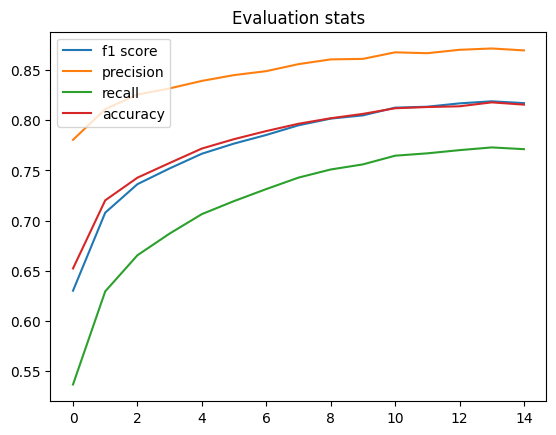

In [67]:
# plot metrics
pyplot.plot(history.history["f1_m"],  label="f1 score")
pyplot.plot(history.history["precision_m"], label="precision")
pyplot.plot(history.history["recall_m"], label="recall")
pyplot.plot(history.history['acc'] , label="accuracy")
pyplot.title('Evaluation stats')
pyplot.legend(loc="upper left")
pyplot.show()

In [68]:
# serialize model to JSON
model_json = model.to_json()
with open("model.json", "w") as json_file:
    json_file.write(model_json)
# serialize weights to HDF5
model.save_weights("model.h5")
print("Saved model to disk")

Saved model to disk


In [71]:
# load json and create model
from keras.models import model_from_json 

json_file = open('model.json', 'r')
loaded_model_json = json_file.read()
json_file.close()
loaded_model = model_from_json(loaded_model_json)
# load weights into new model
loaded_model.load_weights("model.h5")
print("Loaded model from disk")
 
# evaluate loaded model on test data
loaded_model.compile(loss='categorical_crossentropy', optimizer='rmsprop', metrics=['accuracy'])
score = loaded_model.evaluate(x_val, y_val, verbose=0)
print("%s: %.2f%%" % (loaded_model.metrics_names[1], score[1]*100))

Loaded model from disk
accuracy: 74.07%
